# Geolocation project

## Prepare Device Status Data

#### Distributed Data and Data Engineering Spring 2020

#### By: Sam Watson

Review the contents of the file data/devicestatus.txt. Upload this file to a S3 bucket. You will  have  to  pre-process  the  data  in  order  to  get  it  into  a  standardized  format  for  later processing. This is    a common part of the ETL (Extract-Load-Transform) process calleddata scrubbing.

The input data contains information collected from mobile devices on Loudacre’s network, including device ID, current status, location and so on. Loudacre Mobile is a (fictional) fast- growing  wireless  carrier  that  provides  mobile  service  to  customers  throughout  western  USA. Because Loudacre previously acquired other mobile provider’s networks, the data from different subnetworks has a different format. Note that the records in this file have different field delimiters: some use commas, some use pipes (|) and so on.

Your task is to use PySpark in Jupyter Notebooks to:
- Load the dataset
- Determine which delimiter to use (hint: the character at position 19 is the first use of the delimiter)
- Filter  out  any  records  which  do  not  parse  correctly  (hint:  each  record  should  have  exactly 14 values)
- Extract the date (first field), model (second field), device ID (third field), and latitude and  longitude  (13th  and  14th  fields  respectively).  You might  want  to  store  latitude  and longitude as the first two fields to make it consistent with the other two datasets.
- Filter out locations that have a latitude and longitude of 0. 
- The model field contains the device manufacturer and model name (e.g. Ronin S2.) Split this field by spaces to separate the manufacturer from the model (e.g. manufac- turer Ronin, model S2.)
- Save the extracted data to comma delimited text files in S3. 
- Confirm that the data in the file(s) was saved correctly. Provide a screenshot nameddevicedata.pngshowing a couple of records in your Github repository.
- Visualize  the  (latitude,  longitude)  pairs  of  the  device  location  data.  You do  not  have  to  use SPARK for  the  visualization.  You  can  use  any  technique  and  3rd  party  library 

In [2]:
#importing pyspark
from pyspark import SparkContext

In [3]:
#getting SparkContext
sc=SparkContext.getOrCreate()

In [1]:
filepath="s3a://geocluster/dataset1"

In [4]:
#loading the dataset
lines=sc.textFile(str(filepath)+"/devicestatus.txt")

In [5]:
type(lines)

pyspark.rdd.RDD

In [6]:
#first 15 rows
lines.take(15)

[u'2014-03-15:10:10:20,Sorrento F41L,8cc3b47e-bd01-4482-b500-28f2342679af,7,24,39,enabled,disabled,connected,55,67,12,33.6894754264,-117.543308253',
 u'2014-03-15:10:10:20|MeeToo 1.0|ef8c7564-0a1a-4650-a655-c8bbd5f8f943|0|31|63|70|39|27|enabled|enabled|enabled|37.4321088904|-121.485029632',
 u'2014-03-15:10:10:20|MeeToo 1.0|23eba027-b95a-4729-9a4b-a3cca51c5548|0|20|21|86|54|34|enabled|enabled|enabled|39.4378908349|-120.938978486',
 u'2014-03-15:10:10:20,Sorrento F41L,707daba1-5640-4d60-a6d9-1d6fa0645be0,8,22,60,enabled,enabled,disabled,68,91,17,39.3635186767,-119.400334708',
 u'2014-03-15:10:10:20,Ronin Novelty Note 1,db66fe81-aa55-43b4-9418-fc6e7a00f891,0,13,47,70,enabled,enabled,enabled,10,45,33.1913581092,-116.448242643',
 u'2014-03-15:10:10:20,Sorrento F41L,ffa18088-69a0-433e-84b8-006b2b9cc1d0,3,10,36,enabled,connected,enabled,53,58,42,33.8343543748,-117.330000857',
 u'2014-03-15:10:10:20,Sorrento F33L,66d678e6-9c87-48d2-a415-8d5035e54a23,1,34,74,enabled,disabled,enabled,57,42,15,3

#### Above are the first 15 lines in the RDD. There are three different types of delimiters being used here: ",", "|", and "/".

#### To parse the data uniformly, I replaced the "/" and "|" in the each line with a ",".

In [7]:
replace=lines.map(lambda string: string.replace("/",",")).map(lambda string: string.replace("|",","))

#### Afterwards, I split each line by the (now standardized) delimeter ","

In [9]:
linesplit=replace.map(lambda element: element.split(","))

#### Then, I counted the lengths of the lists on each line in the RDD, and remove duplicates. If the steps above truly make the uniform, then all lists should have 14 elements, and the output of the below cell will have 1 value, 14.

In [10]:
linesplit.map(lambda x: len(x)).distinct().collect()

[14]

#### Next, I am only keeping selected columns. I will only be keeping the latitute/longitute (13th and 14th element), the date (first element), the model (second field), and the device id (third field). 

#### I needed to convert the list to a numpy array to grab specific indicies in my list. At the end, I convert the array back to a list 

In [30]:
import numpy as np
data=linesplit.map(lambda x: np.asarray(x)[[12,13,0,1,2]]).map(lambda x: x.tolist())

In [31]:
data.take(2)

[[u'33.6894754264',
  u'-117.543308253',
  u'2014-03-15:10:10:20',
  u'Sorrento F41L',
  u'8cc3b47e-bd01-4482-b500-28f2342679af'],
 [u'37.4321088904',
  u'-121.485029632',
  u'2014-03-15:10:10:20',
  u'MeeToo 1.0',
  u'ef8c7564-0a1a-4650-a655-c8bbd5f8f943']]

#### From there, I filter out locations where the latitute and longitute (now the first and second field) equal 0.

In [32]:
data=data.filter(lambda x: x[0]!='0').filter(lambda x: x[1]!='0')
data.count()

94039

#### Finally, I separate out the device manufacturer and model name from the model field (now the 4th list element). This is done by splitting the model field by spaces. I then take the first two elements of that splitted string, and tack them on at the end of my row as two new columns.

In [50]:
data=data.map(lambda x: x+x[3].split(" ")[:2])

#### Just to make sure I didn't add more fields than I should of:

In [51]:
data.map(lambda x: len(x)).distinct().collect()

[7]

#### Great! Now i have an RDD, containing the fields: 
#### (latitude, longitude, timestamp, the full model name, the device id, the model manufacturer, and the model name).

#### Now, I will save the cleaned data as a csv file back in my S3 Bucket

In [70]:
data.saveAsTextFile("s3a://geocluster/dataset1/dataset1clean.csv")

#### Showing that data was sucessfully loaded into s3:

In [82]:
loaddata=spark.read.format('csv').options(header='false').load("s3a://geocluster/dataset1/dataset1clean.csv")

In [83]:
loaddata.take(5)

[Row(_c0=u"[u'33.6894754264'", _c1=u" u'-117.543308253'", _c2=u" u'2014-03-15:10:10:20'", _c3=u" u'Sorrento F41L'", _c4=u" u'8cc3b47e-bd01-4482-b500-28f2342679af'", _c5=u" u'Sorrento'", _c6=u" u'F41L']"),
 Row(_c0=u"[u'37.4321088904'", _c1=u" u'-121.485029632'", _c2=u" u'2014-03-15:10:10:20'", _c3=u" u'MeeToo 1.0'", _c4=u" u'ef8c7564-0a1a-4650-a655-c8bbd5f8f943'", _c5=u" u'MeeToo'", _c6=u" u'1.0']"),
 Row(_c0=u"[u'39.4378908349'", _c1=u" u'-120.938978486'", _c2=u" u'2014-03-15:10:10:20'", _c3=u" u'MeeToo 1.0'", _c4=u" u'23eba027-b95a-4729-9a4b-a3cca51c5548'", _c5=u" u'MeeToo'", _c6=u" u'1.0']"),
 Row(_c0=u"[u'39.3635186767'", _c1=u" u'-119.400334708'", _c2=u" u'2014-03-15:10:10:20'", _c3=u" u'Sorrento F41L'", _c4=u" u'707daba1-5640-4d60-a6d9-1d6fa0645be0'", _c5=u" u'Sorrento'", _c6=u" u'F41L']"),
 Row(_c0=u"[u'33.1913581092'", _c1=u" u'-116.448242643'", _c2=u" u'2014-03-15:10:10:20'", _c3=u" u'Ronin Novelty Note 1'", _c4=u" u'db66fe81-aa55-43b4-9418-fc6e7a00f891'", _c5=u" u'Ronin'", _c

#### Now Lets do a quick visualization of the data!

In [92]:
import matplotlib.pyplot as plt

In [136]:
lats=data.map(lambda x: x[0]).collect()
longs=data.map(lambda x: x[1]).collect()

In [137]:
def floatconvert(l):
    l2=[]
    for el in l:
        l2.append(float(el))
    return l2

In [138]:
lats=floatconvert(lats)
longs=floatconvert(longs)

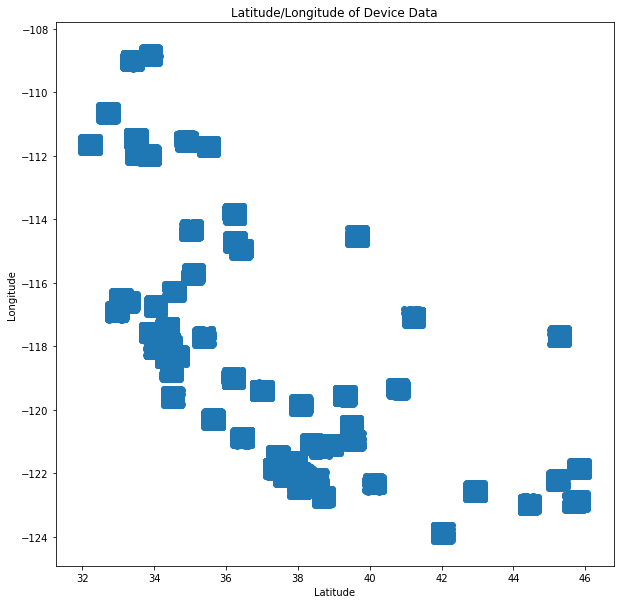

In [153]:
plt.figure(figsize=(10,10))
plt.scatter(lats,longs,)
plt.title("Latitude/Longitude of Device Data")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.show()

#### Neat!